In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import plotly.graph_objects as go
import plotly.express as px
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import callbacks
import seaborn as sns
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K
import tensorflow_hub as hub
import matplotlib.image as img


2025-11-16 15:42:28.145685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763307748.388154      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763307748.455507      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [4]:
train_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"

test_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

img_size = (224 , 224)

batch_size = 32

In [5]:
#Define train_data 
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir ,
    image_size = img_size ,
    label_mode = "int" ,
    batch_size = batch_size ,
    )

#Define Classes Names
class_names= train_data.class_names
class_names

Found 5712 files belonging to 4 classes.


I0000 00:00:1763307977.996897      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763307977.997641      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


['glioma', 'meningioma', 'notumor', 'pituitary']

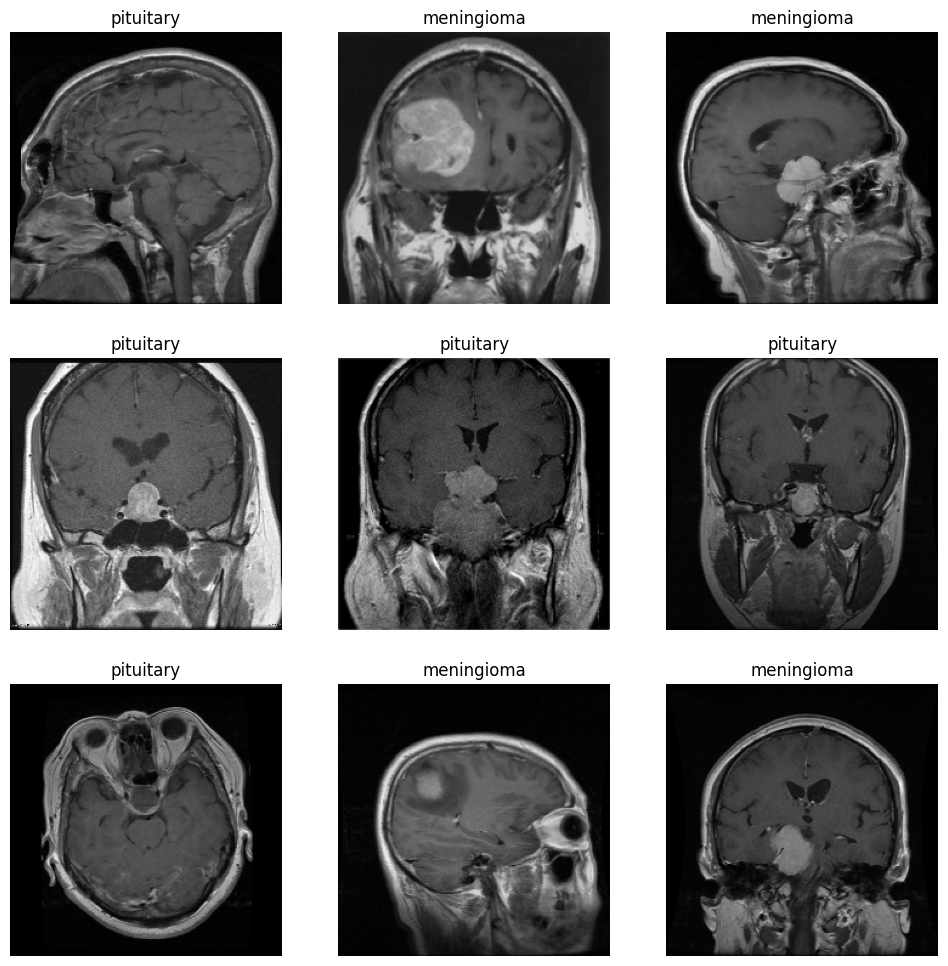

In [7]:
plt.figure(figsize=(12, 12))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
#Deifne a Function to get number of each class samples
def each_class_samples(train_data):
    """
    taking the train data and returns the number of each class samples 
    
    """
    #Set up counters
    meningioma = 0
    notumor = 0
    glioma = 0
    pituitary = 0
    
    #Looping over the train_data
    for images, labels in train_data:
        for i in range(len(images)):
            if class_names[labels[i]] == 'meningioma':
                meningioma +=1
            elif class_names[labels[i]] == 'notumor':
                notumor +=1
            elif class_names[labels[i]] == 'glioma':
                glioma +=1
            elif class_names[labels[i]] == 'pituitary':
                pituitary +=1   
    print("meningioma : " + str(meningioma))
    print("glioma : " + str(glioma))
    print("notumor : " + str(notumor))
    print("pituitary : " + str(pituitary))
    return [meningioma , glioma , notumor , pituitary]




#Trying our function 
meningioma  , glioma , notumor , pituitary = each_class_samples(train_data)

meningioma : 1339
glioma : 1321
notumor : 1595
pituitary : 1457


In [10]:
# Plotting numbers of each class
fig = go.Figure(go.Bar(
            x= [meningioma,glioma,pituitary,notumor],
            y= ['meningioma','glioma','pituitary','notumor'],
            orientation='h' ,) )

fig.update_layout(title='Brain Tumor Distribution',font_size=15,title_x=0.45)


fig.show()


In [11]:
#Defining some constants
img_size = (224 , 224)
batch_size = 32


#Defining train_data again
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,)


#Defining Test_data
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,)


#Defining CallBack list

callback_list=[
    callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.8,monitor="val_accuracy",patience=3)
]

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [12]:
#--Define Base_Model (EfficientNetB0)

base_model = tf.keras.applications.EfficientNetB0(include_top = False) #excluding the top layer 

base_model.trainable = False #--> Freezing the model parameters (Make it's parameter not learnable)

inputs = tf.keras.layers.Input(shape = (224 , 224 , 3) , name = "Input_layer") #--> Define the input layer

x = base_model(inputs)  

x = Conv2D(32 , 3 , padding = 'same' , activation = "relu" , name = "Top_Conv_Layer")(x) #--> add a Conv2D layer which we will use in the segmentation as the Top conv Layer

x = tf.keras.layers.GlobalAveragePooling2D(name = "Global_avg_Pooling_2D")(x) #--> Add Global Average Pooling Layer 2D

outputs = tf.keras.layers.Dense(4 , #--> Because we have 4 Classes
                                activation = "softmax" , #we will change it to linear when we apply sigmentation
                                name = "Output_layer")(x) 
Model_1 = tf.keras.Model(inputs , outputs) #--> Defining the model 


#Compile the model 

Model_1.compile(
    loss = tf.keras.losses.categorical_crossentropy ,#--> Multiclass classification
    optimizer = tf.keras.optimizers.Adam() , #--> Adam optimizer with Learning_rate = 0.001
    metrics = ['accuracy'] 
)


#Fitting the model for 5 epochs 

Model_1_History = Model_1.fit(train_data 
                              , validation_data = test_data ,
                              epochs = 5  ,
                              verbose = 1 ,
                              callbacks = callback_list)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


I0000 00:00:1763308083.175586     115 service.cc:148] XLA service 0x7ad8f0213f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763308083.176388     115 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763308083.176408     115 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763308085.078361     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/179 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.4531 - loss: 1.2645    

I0000 00:00:1763308094.757817     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 162ms/step - accuracy: 0.8043 - loss: 0.4943 - val_accuracy: 0.9123 - val_loss: 0.2507 - learning_rate: 0.0010
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9221 - loss: 0.2106 - val_accuracy: 0.9252 - val_loss: 0.1869 - learning_rate: 0.0010
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9439 - loss: 0.1530 - val_accuracy: 0.9497 - val_loss: 0.1361 - learning_rate: 0.0010
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9513 - loss: 0.1397 - val_accuracy: 0.9451 - val_loss: 0.1496 - learning_rate: 0.0010
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9715 - loss: 0.0842 - val_accuracy: 0.9535 - val_loss: 0.1244 - learning_rate: 0.0010


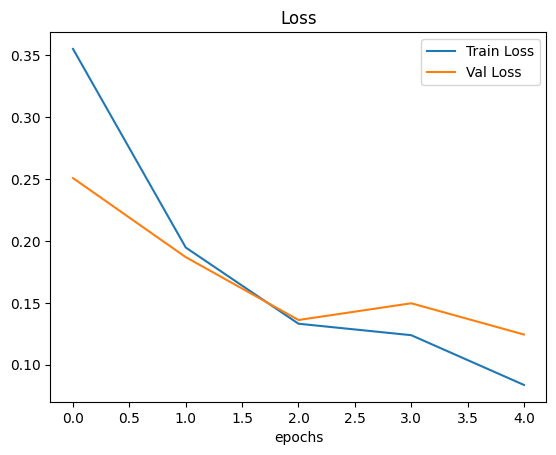

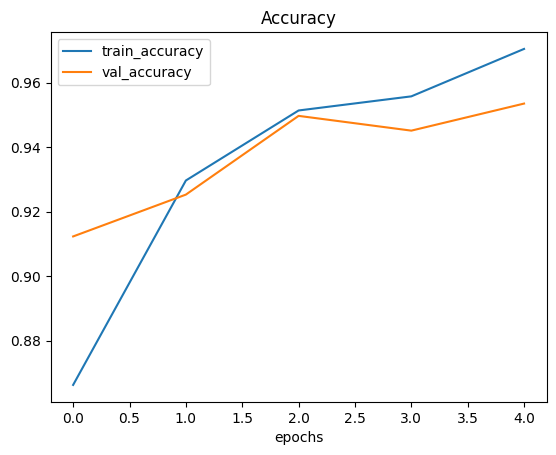

In [14]:
#Define the function to plot loss and accuracy curves of train - valid 
def plot_loss_curves(history):
    train_loss = history.history["loss"]
    val_loss = history.history['val_loss']
    train_accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    #Plot Loss
    plt.plot(epochs , train_loss , label = "Train Loss")
    plt.plot(epochs , val_loss , label = "Val Loss" )
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()
    #Plot accuracy
    plt.figure()
    plt.plot(epochs ,train_accuracy , label = "train_accuracy")
    plt.plot(epochs , val_accuracy , label = "val_accuracy" )
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

#Use out function 
plot_loss_curves(Model_1_History)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import itertools

# --- Step 1: Get predictions and true labels ---
y_true = []
y_pred = []

for images, labels in test_data:
    preds = Model_1.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = test_data.class_names  # ['notumor', 'meningioma', 'glioma', 'pituitary']

# --- Step 2: Classification Report ---
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━

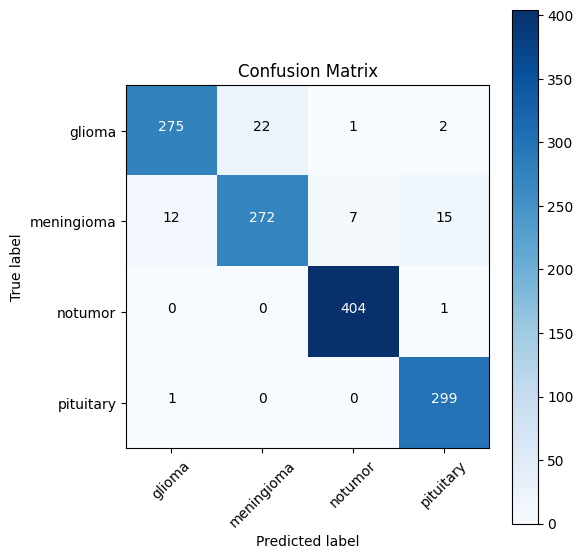

In [16]:
# --- Step 3: Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Annotate cells
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━

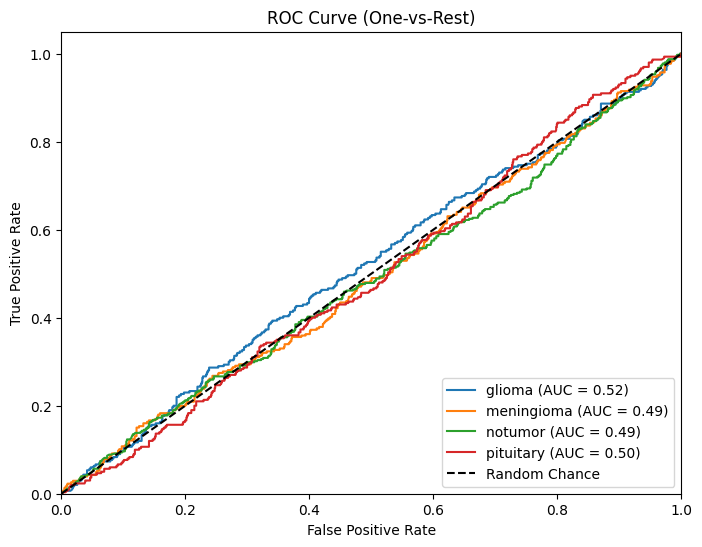

In [17]:
# --- Step 4: ROC Curve (multi-class) ---
from sklearn.preprocessing import label_binarize

# Binarize true labels for ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

# Get prediction probabilities
y_score = []
for images, _ in test_data:
    preds = Model_1.predict(images)
    y_score.extend(preds)

y_score = np.array(y_score)

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

In [18]:
# Un freaze all the Base_model 
base_model.trainable = True

#Freezing all the layers except last 10 
for layer in base_model.layers[:-10]:
    layer.trainable = False


#ReCompile the model 
Model_1.compile(loss = "categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001), #--< When FineTuning u want to lower the LR by 10x
                metrics = ["accuracy"]
               )


#FineTune for 10 epochs 
initial_epoch = 5

Fine_Tune_epoch = initial_epoch + 5

#Refit the model 
Stage_2_history = Model_1.fit(train_data ,
                              epochs = Fine_Tune_epoch , 
                              validation_data = test_data ,
                              validation_steps = len(test_data) ,
                              initial_epoch = initial_epoch-1)

Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 47s 146ms/step - accuracy: 0.9561 - loss: 0.1191 - val_accuracy: 0.9580 - val_loss: 0.1082
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9835 - loss: 0.0547 - val_accuracy: 0.9710 - val_loss: 0.0762
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9840 - loss: 0.0453 - val_accuracy: 0.9733 - val_loss: 0.0717
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9882 - loss: 0.0371 - val_accuracy: 0.9664 - val_loss: 0.1011
Epoch 9/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9903 - loss: 0.0342 - val_accuracy: 0.9725 - val_loss: 0.0637
Epoch 10/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9940 - loss: 0.0235 - val_accuracy: 0.9794 - val_loss: 0.0556


In [ ]:
#ReCompile the model and reduce Learning rate by 10x
Model_1.compile(loss = "categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001), #--< lower the LR by 10x
                metrics = ["accuracy"]
               )
initial_epoch = 10
Fine_Tune_epoch = initial_epoch + 1
#Refit the model for 2 more epochs
Stage_2_history = Model_1.fit(train_data ,
                              epochs = Fine_Tune_epoch , 
                              validation_data = test_data ,
                              validation_steps = len(test_data) ,
                              initial_epoch = initial_epoch-1)

In [ ]:
#ReCompile the model and reduce Learning rate by 10x
Model_1.compile(loss = "categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001), #--< lower the LR by 10x
                metrics = ["accuracy"]
               )
initial_epoch = 10
Fine_Tune_epoch = initial_epoch + 1
#Refit the model for 2 more epochs
Stage_2_history = Model_1.fit(train_data ,
                              epochs = Fine_Tune_epoch , 
                              validation_data = test_data ,
                              validation_steps = len(test_data) ,
                              initial_epoch = initial_epoch-1)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Fine-Tuned Model")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Annotate each cell
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# --- Step 4: ROC Curve ---
# Binarize the labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

# Get probability predictions
y_score = []
for images, _ in test_data:
    preds = Model_1.predict(images)
    y_score.extend(preds)
y_score = np.array(y_score)

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest) - Fine-Tuned Model')
plt.legend(loc="lower right")
plt.show()

Epoch 10/11
179/179 ━━━━━━━━━━━━━━━━━━━━ 46s 142ms/step - accuracy: 0.9958 - loss: 0.0172 - val_accuracy: 0.9825 - val_loss: 0.0478
Epoch 11/11
 33/179 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9989 - loss: 0.0132

In [ ]:
# save model
Model_1.save("brain_tumor_model.h5") 

from tensorflow import keras

Model_1 = keras.models.load_model("brain_tumor_model.h5")

In [ ]:
#Define Some Functions :
last_conv_layer_name = "Top_Conv_Layer"

def get_img_array(img_path, size = (224 , 224)):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array



def make_gradcam_heatmap(img_array, model = Model_1 , last_conv_layer_name = last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4 , view = False):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    if view :
        display(Image(cam_path))

        
     
def decode_predictions(preds):
    classes = ['Glioma' , 'meningioma' , 'No Tumor' , 'Pituitary']
    prediction = classes[np.argmax(preds)]
    return prediction
def make_prediction (img_path , model = Model_1 , last_conv_layer_name = last_conv_layer_name , campath = "cam.jpeg" , view = False):
    img = get_img_array(img_path = img_path)
    img_array = get_img_array(img_path, size=(224 , 224))
    preds = Model_1.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap , cam_path=campath , view = view)
    return [campath , decode_predictions(preds)]


import matplotlib.pyplot as plt
from PIL import Image as PILImage

def display_gradcam_with_barplot(img_path, model=Model_1, last_conv_layer_name=last_conv_layer_name):
    # Get image array and predictions
    img_array = get_img_array(img_path, size=(224, 224))
    preds = model.predict(img_array)[0]  # shape (4,)
    predicted_class_idx = np.argmax(preds)
    predicted_label = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'][predicted_class_idx]
    confidence_score = preds[predicted_class_idx] * 100
    
    # Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    
    # Superimpose Grad-CAM on original
    save_and_display_gradcam(img_path, heatmap, cam_path="gradcam_temp.jpg", alpha=0.4, view=False)
    
    # Load both images
    original_img = PILImage.open(img_path)
    gradcam_img = PILImage.open("gradcam_temp.jpg")
    
    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Original
    axes[0].imshow(original_img)
    axes[0].set_title(f"Original Image\nPredicted: {predicted_label} ({confidence_score:.2f}%)")
    axes[0].axis("off")
    
    # Grad-CAM
    axes[1].imshow(gradcam_img)
    axes[1].set_title("Grad-CAM Heatmap Overlay")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    # --- Bar plot of all class probabilities ---
    class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    plt.figure(figsize=(6, 4))
    plt.bar(class_names, preds, color='skyblue')
    plt.title("Prediction Probabilities")
    plt.ylabel("Probability")
    plt.ylim([0, 1])
    
    # Annotate probabilities on top
    for i, val in enumerate(preds):
        plt.text(i, val + 0.01, f"{val*100:.2f}%", ha='center', fontsize=9)
    
    plt.show()
    

In [ ]:
# example 1
display_gradcam_with_barplot("/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0010.jpg")

In [ ]:
# example 2
display_gradcam_with_barplot("/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0005.jpg")

In [ ]:
# example 3
display_gradcam_with_barplot("/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0006.jpg")

In [ ]:
# Zip the trained model
!zip brain_tumor_model.zip /kaggle/working/brain_tumor_model.h5

# Create a clickable download link
from IPython.display import FileLink
FileLink('brain_tumor_model.zip')